## Import libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import xlrd 
import datetime
import os

---

## Prepare data for cleaning

In [3]:
data_folder = Path("data") # Path to the data folder
all_csv = list(data_folder.glob("*.csv")) # List of all the csv files in the data folder

---

## Manage date-time format

In [4]:
def icmp_dateformat_to_datetime(icmp_time_mark):
    """
    Convert ICMP time mark to datetime format
    
    Args:
        icmp_time_mark (float): ICMP time mark
    
    Returns:
        datetime_date (datetime): Datetime format of ICMP time mark
    """
    datetime_date = xlrd.xldate_as_datetime(icmp_time_mark, 0)
    datetime_date = datetime_date + datetime.timedelta(hours=1)
    return datetime_date

In [5]:
def time_encoder(df):
  """
  Encode time features from datetime column
  
  Args:
      df (DataFrame): Dataframe to encode time features
      
  Returns:
      df (DataFrame): Dataframe with encoded time 
  """
  df['time'] = pd.to_datetime(df['DateTime'])
  return df

In [6]:
data_frames = {}
for file in tqdm(all_csv):
  df = pd.read_csv(file, sep=";", decimal=",") # read csv file
  
  df['DateTime'] = df['DateTime'].apply(icmp_dateformat_to_datetime) # convert icmp time mark to datetime
  df = time_encoder(df) # encode time features
  
  data_frames[file.stem] = df # store all patients data in one dictionary

100%|██████████| 3/3 [00:00<00:00, 15.48it/s]


---

## Cancel unused data

In [7]:
for key, df in tqdm(data_frames.items()):
    data_frames[key] = df.drop(columns=['TEMP', 'cpp', 'AMP'])

100%|██████████| 3/3 [00:00<00:00, 752.12it/s]


In [8]:
for key, df in tqdm(data_frames.items()):
    data_frames[key] = df.dropna()

100%|██████████| 3/3 [00:00<00:00, 601.56it/s]


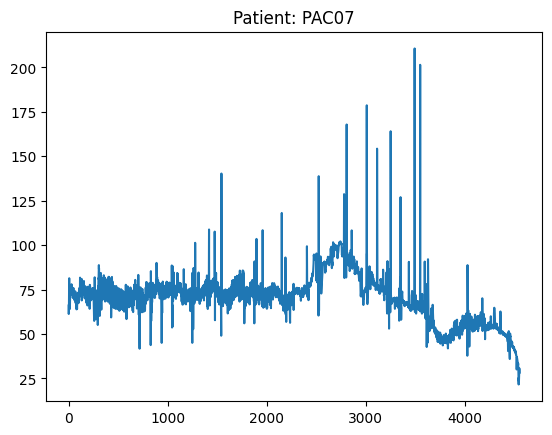

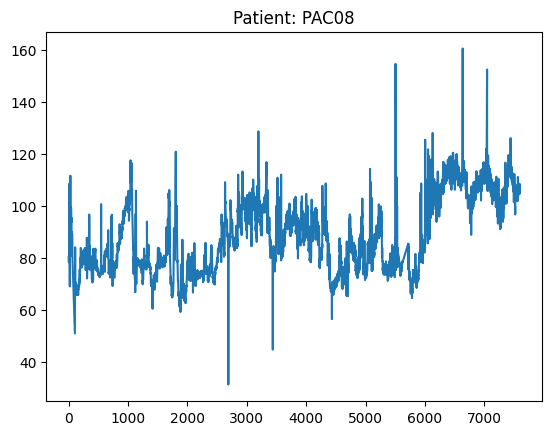

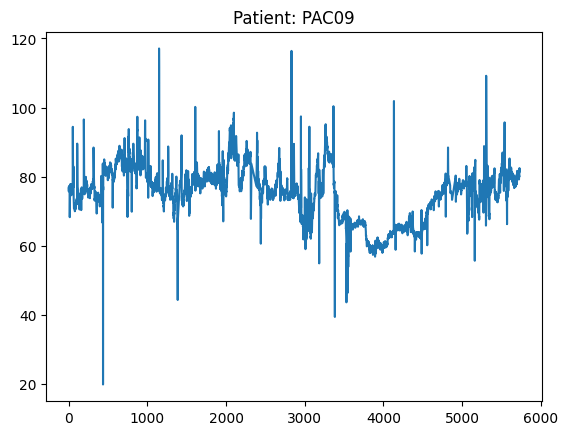

In [9]:
for patient in data_frames.keys():
    data_frames[patient]['ABP'].plot(title=f"Patient: {patient}")
    plt.show()

---

## Calculate differences between data and create slices 

- this would be later used to detect artifacts 

In [10]:
def calculate_differences(data):
    """
    Calculate the differences between the timestamps in the data
    
    Args:
    data (pd.DataFrame): Dataframe containing the timestamps
    
    Returns:
    data (pd.DataFrame): Dataframe containing the timestamps and the differences between them
    
    """
    data['diff_sec'] = data['time'].diff().dropna()
    data['diff_sec'] = data['diff_sec'].apply(lambda x: x.total_seconds())
    return data

In [11]:
def slice_data_by_diff_in_sampling(data):
    """
    Slice data if there is difference in sampling 
    
    Args:
        data (pd.DataFrame): Data to be sliced
    
    Returns:
        sliced_data (pd.DataFrame): Sliced data
    """
    NORMAL_SAMPLING_VALUE_SECONDS = 60 
    data = calculate_differences(data)
    slices = []
    start_of_a_new_slice = 0
    for i in range(len(data)):
        if data['diff_sec'].iloc[i] != NORMAL_SAMPLING_VALUE_SECONDS:
          slices.append(data.iloc[start_of_a_new_slice:i])
          start_of_a_new_slice = i
    slices.append(data.iloc[start_of_a_new_slice:])    
    return slices

In [12]:
def analize_slices(slices):
  """
  Analize slices of data
  
  Args:
      slices (list): List of data slices
  
  Returns:
      None
  """
  for slice in slices:
    plt.plot(slice['ABP'])

In [13]:
patient_sliced_data = {}
for patient in data_frames.keys():
  sliced_data = slice_data_by_diff_in_sampling(data_frames[patient])
  patient_sliced_data[patient] = sliced_data

C:\Users\damia\AppData\Local\Temp\ipykernel_16232\3938392293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['diff_sec'] = data['time'].diff().dropna()
C:\Users\damia\AppData\Local\Temp\ipykernel_16232\3938392293.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['diff_sec'] = data['diff_sec'].apply(lambda x: x.total_seconds())


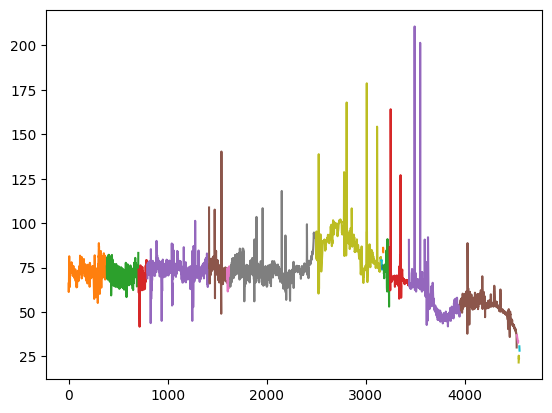

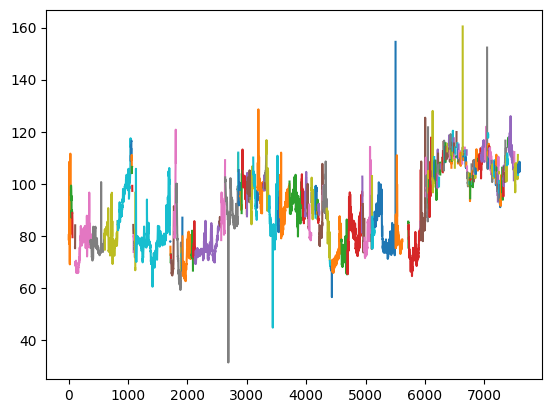

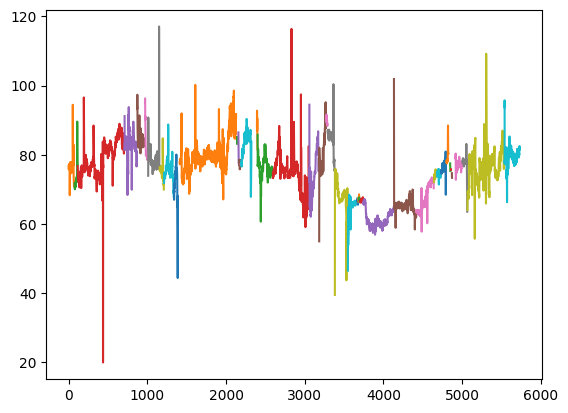

In [14]:
for patient in patient_sliced_data:
  analize_slices(patient_sliced_data[patient])
  plt.show()

** This feature can also be excluded for now

---

## Based on local avg find outliers and interpolate them. 

In [15]:
def find_outliers(data):
    """
    Find outliers in the data, following the IQR method
    
    Args:
        data (pd.DataFrame): Data to find outliers in
    
    Returns:
        outliers (pd.DataFrame): Outliers in the data

    """
    Q1 = data.quantile(0.30)
    Q3 = data.quantile(0.70)
    IQR = Q3 - Q1
    outliers = data[((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))]
    return outliers

In [16]:

def filter_slices(patient_data):
    """
    Filter slices with more than 10 elements.
    
    Args:
        patient_data (list): List of slices
    
    Returns:
        list: List of slices with more than 10 elements
    """
    return [slice for slice in patient_data if len(slice) > 10]

In [17]:
def find_outliers_in_slices(slices):
    """
    Find outliers in each slice.
    
    Args:
        slices (list): List of slices
    
    Returns:
        outliers (list): List of outliers in each slice
    """
    
    return [find_outliers(slice_data) for slice_data in slices]

In [18]:
def plot_slices_and_outliers(slices, outliers_in_slices):
    """
    Plot each slice and its outliers.
    
    Args:
        slices (list): List of slices
        outliers_in_slices (list): List of outliers in each slice
    
    Returns:
        None
    """
    for i, slice in enumerate(slices):
        slice['ABP'].plot()
        outliers = outliers_in_slices[i]['ABP']
        plt.scatter(outliers.index, outliers, color='red')
    plt.show()

In [19]:
def convert_intersectionts_to_nans(data, outliers):
  """
  Convert the intersection of the data and the outliers to NaNs
  
  Args:
      data (pd.DataFrame): Data to convert intersection to NaNs
      outliers (pd.DataFrame): Outliers to convert intersection to NaNs
  
  Returns:
      data (pd.DataFrame): Data with intersection converted to NaNs
  """
  for col in set(data.columns).intersection(outliers.columns):
    common_values = data[col].isin(outliers[col])
    data.loc[common_values, col] = np.nan
    
  return data

In [20]:
def perform_cleaning(data):
    """
    Perform cleaning on the data
    
    Args:
        data (pd.DataFrame): Data to clean
    
    Returns:
        data (pd.DataFrame): Cleaned data
    """
    
    data = calculate_differences(data) # Calculate differences in the data
    
    slices = slice_data_by_diff_in_sampling(data) # Slice data by difference in sampling
    slices = filter_slices(slices) # Filter slices with more than 10 elements
    outliers_in_slices = find_outliers_in_slices(slices) # Find outliers in each slice
    
    data = convert_intersectionts_to_nans(pd.concat(slices), pd.concat(outliers_in_slices)) # Convert intersection of data and outliers to NaNs
    data.interpolate(inplace=True) # Interpolate the data
    return data

c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


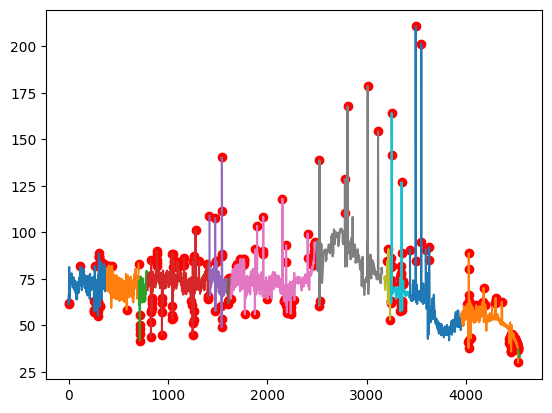

c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


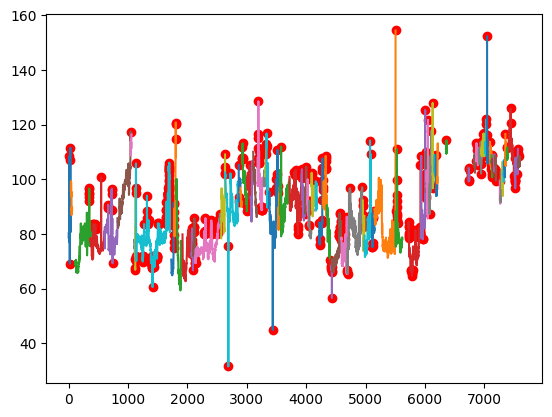

c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


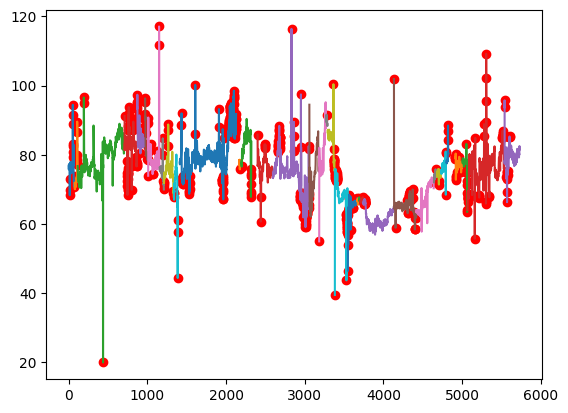

In [21]:
all_outliers = {} 
for patient in patient_sliced_data:
  slices = filter_slices(patient_sliced_data[patient])
  outliers_in_slices = find_outliers_in_slices(slices)
  plot_slices_and_outliers(slices, outliers_in_slices)
  all_outliers[patient] = pd.concat(outliers_in_slices)

c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value 

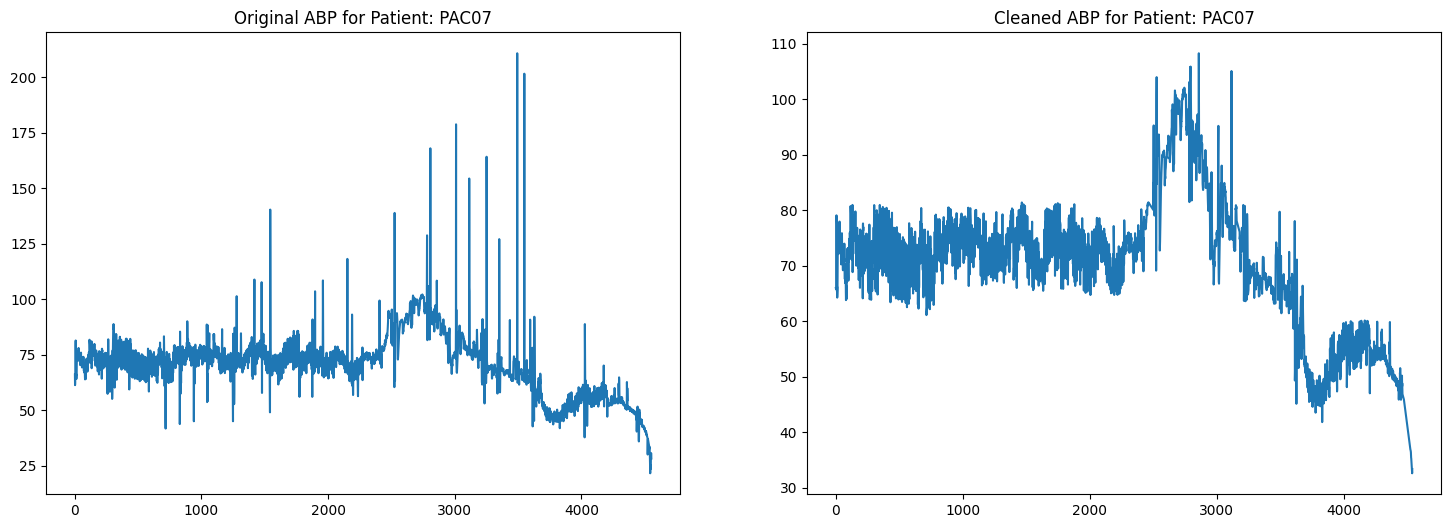

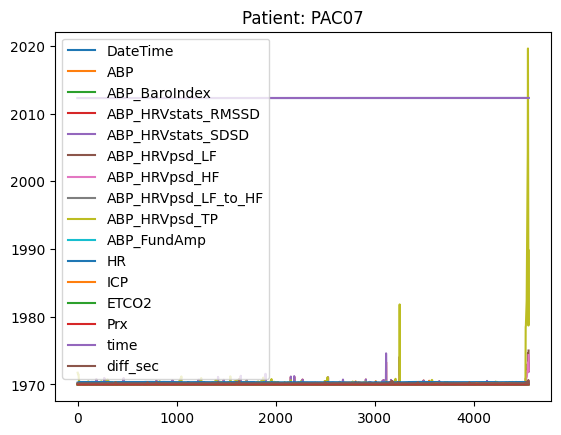

c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
c:\Users\damia\BrainLab\GARCH-FIT\BrainEnv\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value 

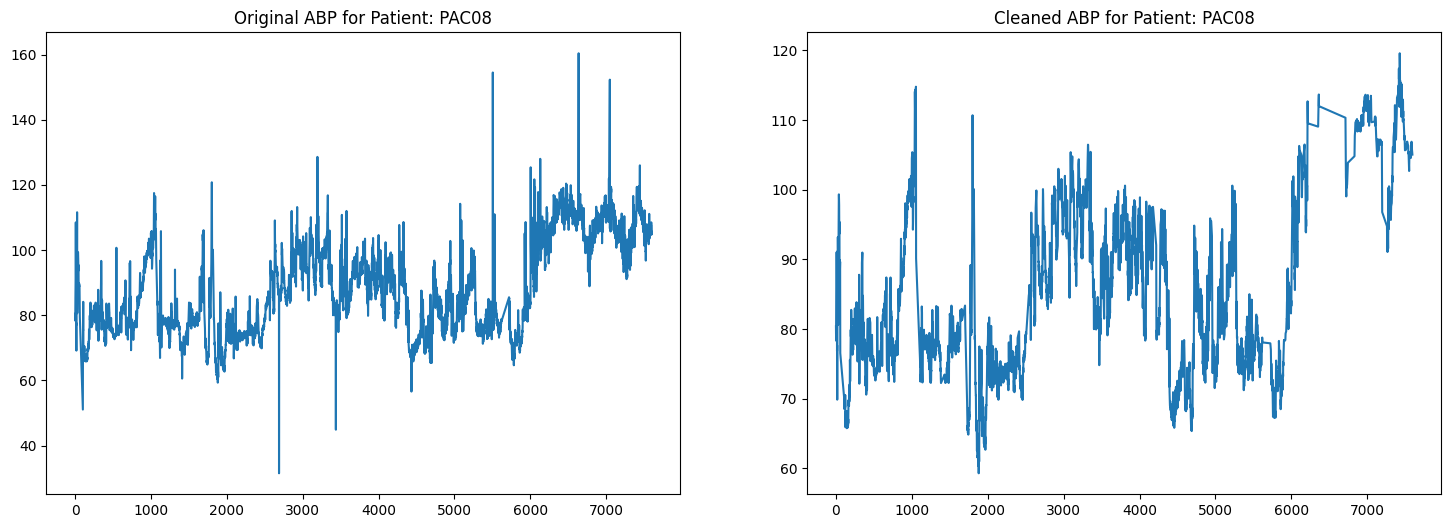

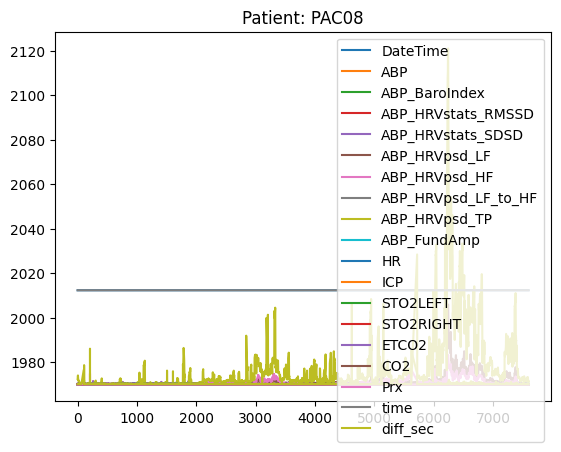

C:\Users\damia\AppData\Local\Temp\ipykernel_16232\3938392293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['diff_sec'] = data['time'].diff().dropna()
C:\Users\damia\AppData\Local\Temp\ipykernel_16232\3938392293.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['diff_sec'] = data['diff_sec'].apply(lambda x: x.total_seconds())
C:\Users\damia\AppData\Local\Temp\ipykernel_16232\3938392293.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

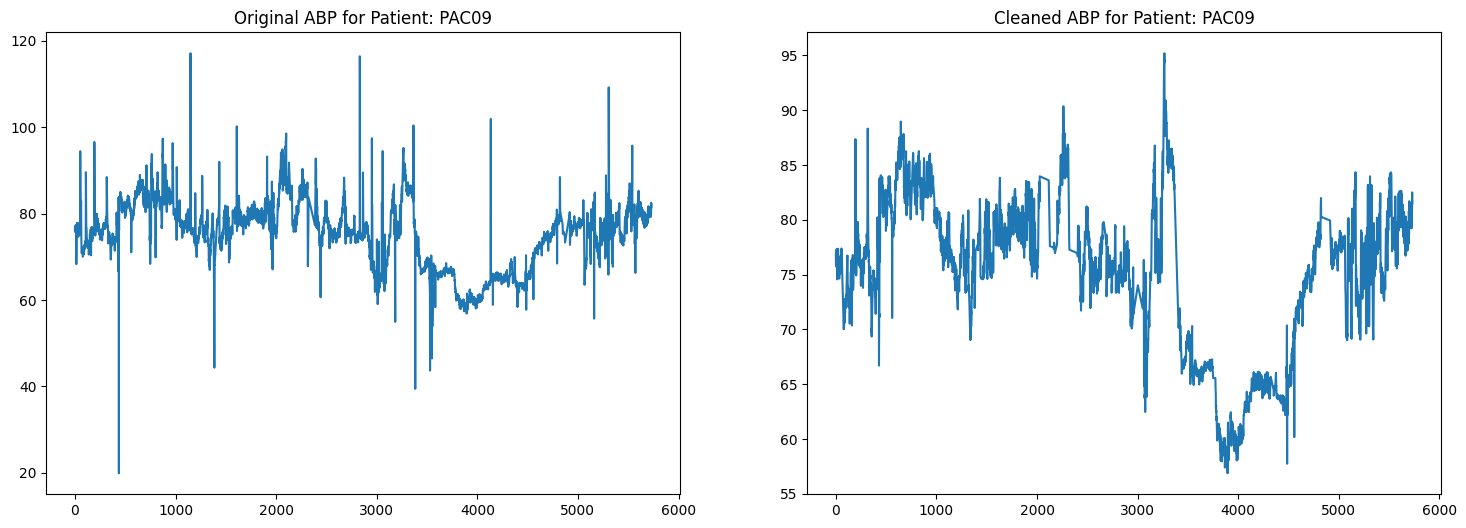

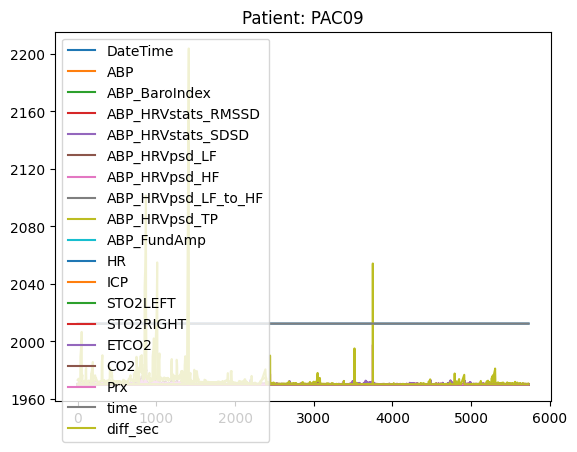

In [22]:
for patient in data_frames.keys():
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    un_cleaned_data = data_frames[patient].copy()
    axs[0].plot(data_frames[patient]['ABP'])
    axs[0].set_title(f"Original ABP for Patient: {patient}")
    un_cleaned_data.plot(title=f"Patient: {patient}")
    
    
    for i in range(20): # Perform cleaning 20 times - It is a good practice to perform cleaning multiple times
        data_frames[patient] = perform_cleaning(data_frames[patient])
        
        
    axs[1].plot(data_frames[patient]['ABP'])
    axs[1].set_title(f"Cleaned ABP for Patient: {patient}")

    plt.show()

In [23]:
if not os.path.exists('data_clean'):
    os.makedirs('data_clean')

In [24]:
for patient in data_frames.keys():
    data_frames[patient].drop(columns=['diff_sec']).to_csv(f"data_clean/{patient}_cleaned.csv", index=False)